# Recurrent Neural Networks (RNN)

The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output depending on the previous computations. Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far. RNNs calculate a hidden state at each step, which depends both on the current step's input and the previous step's hidden state. Here is the update equation of an RNN cell:
$$
h' = \tanh(W_{ih}x + b_{ih} + W_{hh}h + b_{hh})
$$

'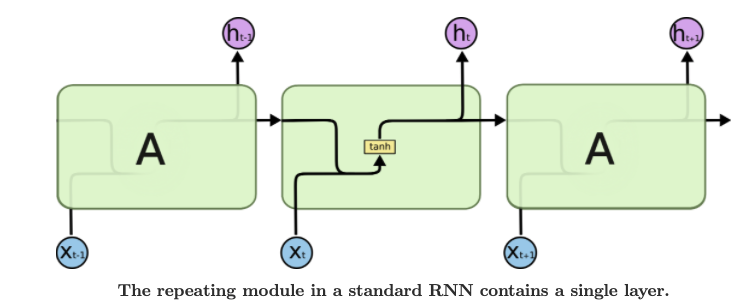'

Here, $x$ is the current input, $h$ is the previous hidden state, and $h'$ is the new hidden state. Although the hidden state depends on all past inputs by definition, the contribution of old inputs can vanish quickly with the future updates trying to absorb information from newer inputs. To improve long-term memory and mitigate training challenges, the LSTM architecture was introduced with a specific design to manage the upcoming new information and information from the past. The LSTM cell has a hidden state and a cell state (just another hidden state with a different functionality). The hidden and cell state are updated at each state based on the current input and the previous hidden and cell state. Here's what happens in an LSTM cell:
$$
i = \sigma(W_{ii}x + b_{ii} + W_{hi}h + b_{hi})
$$
$$
f = \sigma(W_{if}x + b_{if} + W_{hf}h + b_{hf})
$$
$$
g = \tanh(W_{ig}x + b_{ig} + W_{hg}h + b_{hg})
$$
$$
o = \sigma(W_{io}x + b_{io} + W_{ho}h + b_{ho})
$$
$$
c' = f \odot c + i \odot g
$$
$$
h' = o \odot \tanh(c')
$$

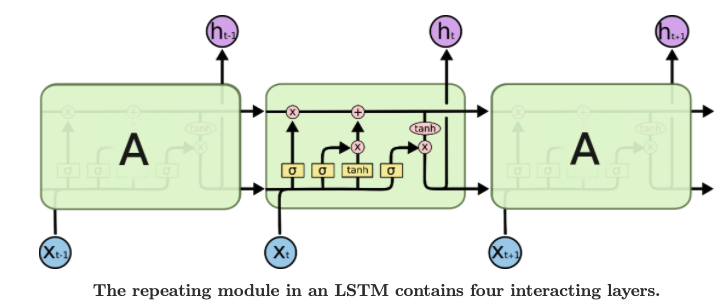


Here, $x$ is the new input, $h$ and $c$ are the previous hidden and cell states, and $h'$ and $c'$ are the new hidden and cell states. This might seem conplicated, but as we break down the procedure, hopefully it will make more sense. 

- $g$ extracts a new feature vector based on the new input $x$ and the previous hidden state $h$. A fraction of $g$ will constitute part of the new cell state $c'$, and the new hidden state $h'$ is going to be a nonlinear function of the new cell state $c'$.

- $i$ is the input __gate__. It determines how much of $g$ to include in the new cell state $c'$. It is always between 0 and 1 (because it is the output of sigmoid), so it is interpreted as a gate for new information. If it is 0, the new information will not be included, and if it is 1, the new information will be included in its totality. You can see this in the update for cell state as $i\odot g$ .

- $f$ is the forget __gate__ (I'd call it remember gate). Its role is to determine how much of the previous cell state value $c$ to include in the new cell state value $c'$. Since it is a gate, its value is always between 0 and 1, so it can choose anywhere between preserving none or all of the previous cell state. You can see this in the update for the cell state as $f \odot c$.

- $c'$ is the new cell state, whose value is calcualted by summing a fraction of the previous cell state value, and a fraction of new information $g$. The amount of the fractions are determined by the forget gate $f$ and the input gate $i$ respectively.

- $o$ is the output __gate__, which is again the sigmoid of the sum of a linear transformation of the new input $x$ and the previous hidden state $h$. The updated cell state $c'$is going to go through another $tanh$ activation, and a certain fraction of the result is going to be the new hidden state $h'$.

- $h'$ is the new hidden state, and is calculated according by applying $tanh$ to $c'$ and then applying the output gate $o$.

Now can you point to each of these variables in the figure?

Now, we will look at [`RNNCell`](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html), [`LSTMCell`](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html), [`RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), and [`LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) from `torch.nn`.

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.nn import functional as F

In [ ]:
# data tensor shape:
batch_size = 13 # Here, size means feature dimension.
input_size = 5 # Here, size means feature dimension. 
seq_len = 20 # NEW

x = torch.randn(batch_size, seq_len, input_size)

## [`RNNCell`](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html) & [`LSTMCell`](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)

The module that is __recurrently__ being used at each step in an RNN is typically called a cell. We are going to implement the sequence processing code explicitly to see what exactly happens.

In [ ]:
"""
Let's create an RNNCell and look at its parameters.
"""
hidden_size = 11

rnn_cell = nn.RNNCell(
    input_size= input_size,
    hidden_size = hidden_size, 
    bias = True, 
    nonlinearity = 'tanh', # tanh or relu only
)

for pname, p in rnn_cell.named_parameters():
    print(pname, ':', tuple(p.shape)) 

# weight_ih: (hidden_size, input_size)
# weight_hh: (hidden_size, hidden_size)
# bias_ih: (hidden_size,)
# bias_hh: (hidden_size,)

In [ ]:
"""
The forward pass needs the previous hidden state and the new input x
"""

# Let's initialize the sequence of the hidden states.
hs = [
    torch.zeros(batch_size, hidden_size, dtype=torch.float32, requires_grad=True) # You can set the initial hidden state to be learnable as well
]

# hs now has one element, which is the initial hidden state

for t in range(seq_len):
    new_h = rnn_cell(x[:, t, ...], hs[-1])
    hs.append(new_h)

print('len(hs) is', len(hs))
print('hs[-1].shape :', hs[-1].shape) # (batch_size, hidden_size)


In [ ]:
"""
If you do not pass a hiddne state, it will assume it is zero.
"""

new_h = rnn_cell(x[:, 0, ...]) # No h passed
print(new_h.shape)

In [ ]:
"""
LSTMCell is similarly defined.
"""

lstm_cell = nn.LSTMCell(
    input_size = input_size,
    hidden_size = hidden_size,
    bias = True,
)

"""
The linear layers of i, f, g, o is implemented as one layer for efficiency.
"""

for pname, p in lstm_cell.named_parameters():
    print(pname, ':', tuple(p.shape))

# weight_ih: (4*hidden_size, input_size)
# weight_hh: (4*hidden_size, hidden_size)
# bias_ih: (4*hidden_size,)
# bias_hh: (4*hidden_size,)

In [ ]:
"""
For the forward pass, we need to do the same thing for c as we did for h.
You can just think of c as another hidden state with a different update mechanism.
Again, If you do not pass the hidden and cell state, it will assume they are zero.
"""
hs = [
    torch.zeros(batch_size, hidden_size, dtype=torch.float32, requires_grad=False) # You may set requires_grad to True
]

cs = [
    torch.zeros(batch_size, hidden_size, dtype=torch.float32, requires_grad=False) # You may set requires_grad to True
]


for t in range(seq_len):
    new_h, new_c = lstm_cell(x[:, t, ...], (hs[-1], cs[-1])) # Pay attention to how the previous h and c are passed!
    hs.append(new_h)
    cs.append(new_c)

print('len(hs) is', len(hs))
print('len(cs) is', len(cs))


## Different sequence prediction tasks

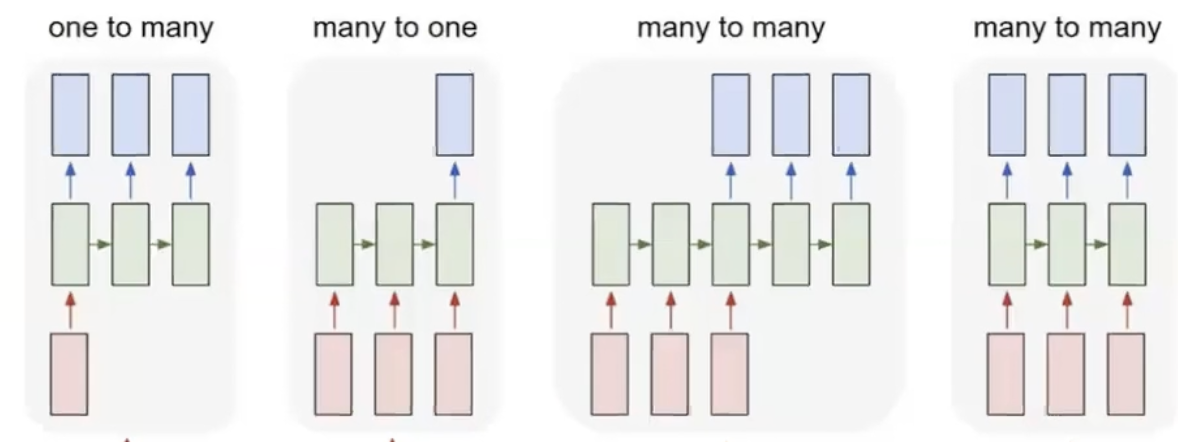

In [ ]:
"""
MANY TO ONE:
If you want to predict a target for the whole sequence, you can the hidden state of the last step
and apply some model to it to get the final prediction.
"""
target_dim = 7

out_layer = nn.Linear(hidden_size, target_dim) # This can be any model

# The last hidden state is the last element of the hs list
last_h = hs[-1]

# Predict the target
sequence_target = out_layer(last_h)

print(sequence_target.shape) # (batch_size, target_dim)

In [ ]:
"""
MANY TO MANY:
If you want to predict a target for each time step, you can use the hidden states at each time step.
But Remember to remove the initial hidden state from the list
"""

out_layer = nn.Linear(hidden_size, target_dim)

# Get the processed hidden states for each step, and concatenating them ovet the sequence dimension:
hs_tensor = torch.stack(hs[1:], dim=1)

print('shape of hs_tensor:', hs_tensor.shape) # shape (batch_size, seq_len, hidden_size)

# Then you can apply whatever model you have to the hs tensor,
pred = out_layer(hs_tensor)
print('shape of pred:', pred.shape) # shape (batch_size, seq_len, target_dim)

For one to many predictions, the one input would be the initial hidden state or the first input. For the future inputs, one can choose to pass a zero tensor, or a processed tensor from the previous hidden or cell state. You can also implement a many to many perdiction by having two different models, where the final hidden (and cell) state of one, is the initial of the other one. 

## [`RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) & [`LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

The RNN and LSTM modules take care of the sequential processing for you, as well as stacking several layers (with the same hidden size). The deeper layers have a similar mechanism with the exception that at each step, their input ($x_t$ in the single-layer case) is the previous layer's new hidden state. They are also called stacked RNN or LSTMs. In the figure below, subscript represents the step index and the superscript represents the layer index.

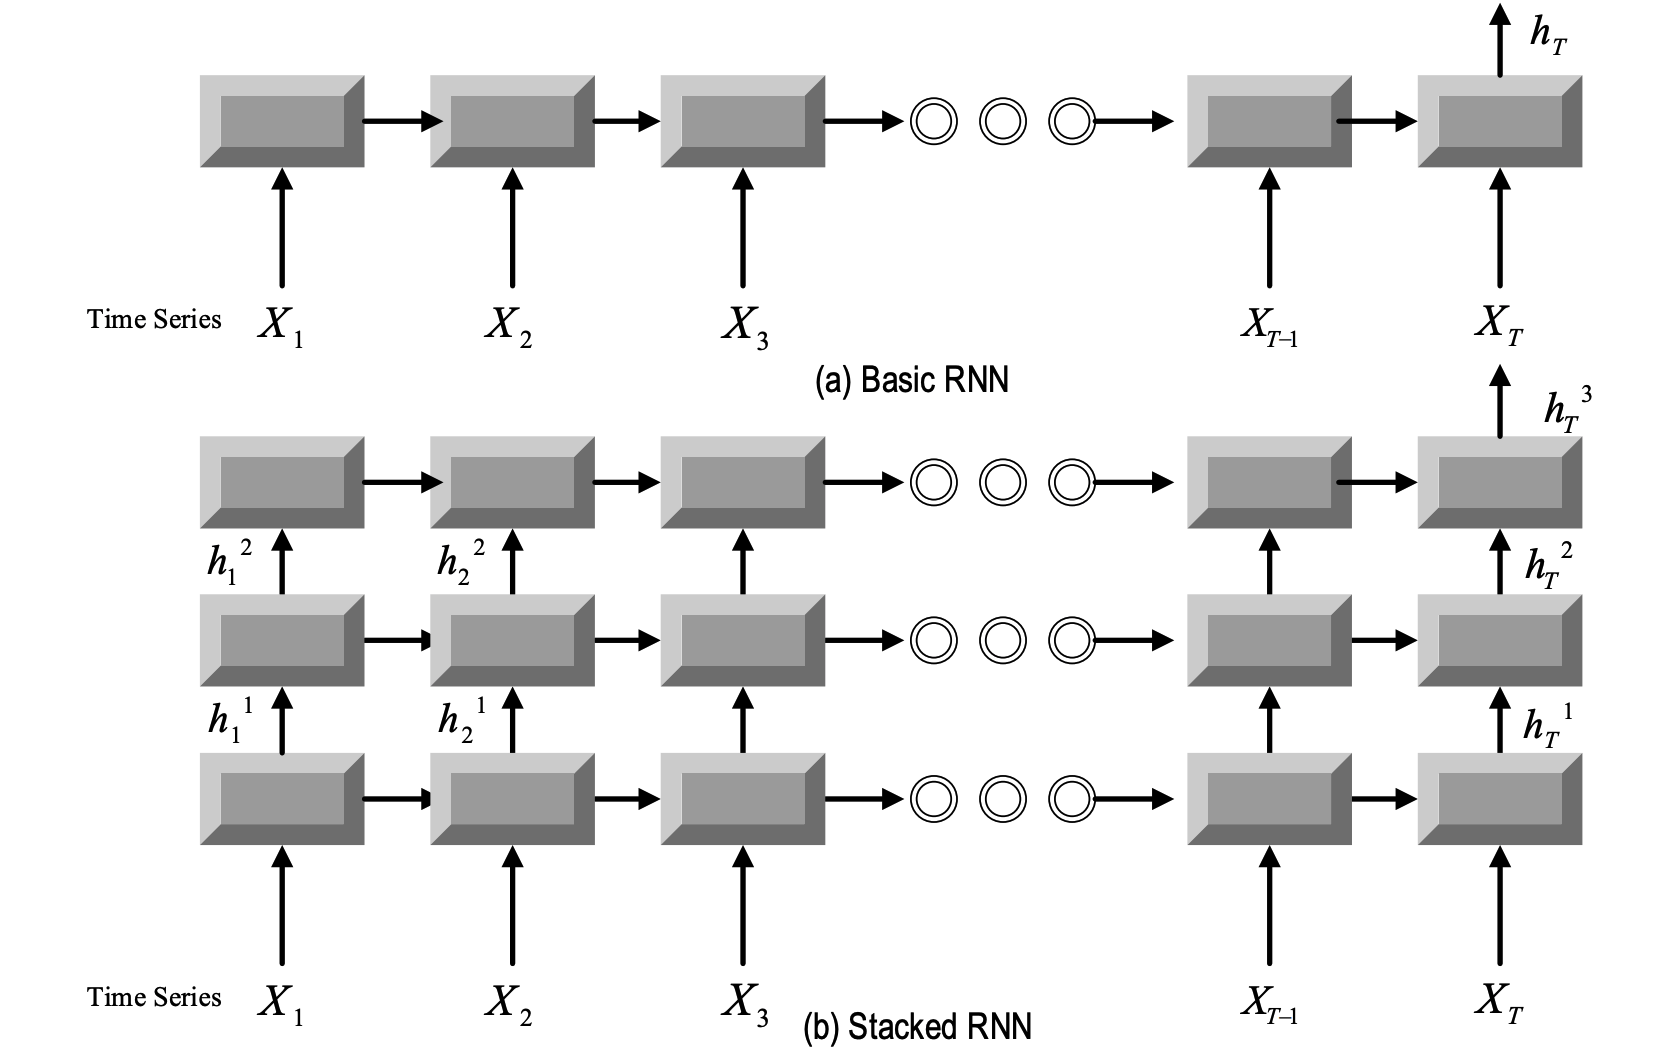

Another option you have in defining the RNN or LSTM is to make it _bidirectional_, which is exactly what is sounds like: similar calculations (but with differnet parameter values) are happening in both directions. This is useful if the dependency does not necessarily happen in one direction, which is the case for words in a sentence. However, for cases that there is a causal relationship between consequent elements, using a bidirectional model would not make sense.

Let's look at some examples of [`RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) and [`LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

In [ ]:
"""
Let's create an RNN and look at its parameters.
"""
n_layers = 3

rnn = nn.RNN(
    input_size = input_size,
    hidden_size = hidden_size,
    num_layers = n_layers,
    bias = True,
    batch_first = True, # MAKE SURE TO SPECIFY THIS
    bidirectional = True,
    dropout = 0.0,
)

for pname, p in rnn.named_parameters():
    print(pname, ':', tuple(p.shape))

"""
First layer has:

weight_ih_l0: (hidden_size, input_size)
weight_hh_l0: (hidden_size, hidden_size)
bias_ih_l0: (hidden_size,)
bias_hh_l0: (hidden_size,)

And similar parameters for the reverse direction.

Second layer has:

weight_ih_l1: (hidden_size, hidden_size*D)
weight_hh_l1: (hidden_size, hidden_size)
bias_ih_l1: (hidden_size,)
bias_hh_l1: (hidden_size,)

and similar parameters for the reverse direction.

D = 2 for bidirectional RNN and 1 otherwise.
Because bidirectionl RNN deeper layers takes the new hidden state
from both directions of the previous layer as input.


The deeper layers are similar to the second layer
"""
None

In [ ]:
"""
RNN takes the whole input sequence, and optionally an initial hidden state.
It returns the whole sequence of hidden states, and the last hidden state of all layers.
"""

x = torch.randn(batch_size, seq_len, input_size)

# The initial hidden state is optional
# WARNING: If you want to define the initial hidden state, make sure the shape is right!
D = 1 if not rnn.bidirectional else 2
initial_h = torch.zeros(n_layers*D, batch_size, hidden_size, dtype=torch.float32, requires_grad=False)

# The forward pass
h_all_steps_last_layer, h_last_step_all_layers = rnn(x, initial_h)

print('shape of h_last_layer_all_steps:', h_all_steps_last_layer.shape) # shape (batch_size, seq_len, hidden_size*D)
print('shape of h_last_step_all_layers:', h_last_step_all_layers.shape) # shape (n_layers*D, batch_size, hidden_size)


In [ ]:
"""
LSTM is similarly defined.
"""

lstm = nn.LSTM(
    input_size = input_size,
    hidden_size = hidden_size,
    num_layers = n_layers,
    bias = True,
    batch_first = True,
    bidirectional = True,
    dropout = 0.0,
    proj_size = 0, # Ad additional layer to apply to hidden states
)

for pname, p in lstm.named_parameters():
    print(pname, ':', tuple(p.shape))

In [ ]:
"""
Forward pass of LSTM is similar to RNN, with an optional initial cell state more.
"""

x = torch.randn(batch_size, seq_len, input_size)

# The initial hidden state is optional
D = 1 if not lstm.bidirectional else 2

initial_h = torch.zeros(n_layers*D, batch_size, hidden_size, dtype=torch.float32, requires_grad=False)
initial_c = torch.zeros(n_layers*D, batch_size, hidden_size, dtype=torch.float32, requires_grad=False)

# The forward pass
h_all_steps_last_layer, (h_last_step_all_layers, c_last_step_all_layers) = lstm(x, (initial_h, initial_c))
print('shape of h_all_steps_last_layer:', h_all_steps_last_layer.shape) # shape (batch_size, seq_len, hidden_size*D)
print('shape of h_last_step_all_layers:', h_last_step_all_layers.shape) # shape (n_layers*D, batch_size, hidden_size)
print('shape of c_last_step_all_layers:', c_last_step_all_layers.shape) # shape (n_layers*D, batch_size, hidden_size)

## Training an RNN

Let's train an RNN (or LSTM) to perdict a sine wave. 

In [ ]:
from tqdm import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
try:
    %matplotlib widget
except:
    import os
    os.system('pip install ipympl -qq')
    %matplotlib widget

from torch.utils.data import Dataset, DataLoader

Device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is', Device)

In [ ]:
class SineWaveDataset(Dataset):

    def __init__(
            self,
            num_samples: int,
            resolution: int,
            noise: float = 0.0,
            ):
        super().__init__()
        # selecting num_samples random phase and frequency
        phase = torch.rand(num_samples, 1) * 2 * torch.pi
        amplitude = torch.rand(num_samples, 1)
        freq = torch.randint(1, 5, (num_samples, 1)).float()
        t = torch.linspace(0, 1, resolution+1)[:-1]

        self.data = torch.sin(2 * torch.pi * freq * t + phase) * amplitude

        # Adding noise
        if noise > 0:
            self.data += torch.randn_like(self.data) * noise

        # Add a single feature dimension
        self.data = self.data.unsqueeze(-1)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int) -> torch.FloatTensor: # (seq_len, 1)
        seq = self.data[idx]
        x = seq[:-1, ...]
        y = seq[1:, ...]
        return x, y


class SeqDataViz:
    """
    An interactive image data visualzation tool inside Juptyer Notebook.
    Make sure to use the magic command: %matplotlib widget
    """
    def __init__(self, dataset: Dataset):
        self.dataset = dataset
        self.n_samples = len(dataset)
        self.index = widgets.IntSlider(
            value=0, 
            min=0, 
            max=self.n_samples-1, 
            step=1, 
            description='Index', 
            continuous_update=True,
            layout=widgets.Layout(width='80%'),
            )

    def update(self, index: int):
        self.line.set_ydata(self.dataset.data[index, ..., 0])
        self.fig.canvas.draw()


    def show(self):
        self.fig, self.ax = plt.subplots()
        x = self.dataset.data[0]
        t = torch.linspace(0, 1, x.shape[0]+1)[:-1]
        self.line, = self.ax.plot(t, x)
        self.ax.set_xlabel('Time')
        self.ax.set_ylabel('Amplitude')
        self.ax.set_ylim(-1, 1)
        self.ax.grid(linestyle='--')
        widgets.interact(self.update, index=self.index)

In [ ]:
dataset = SineWaveDataset(
    num_samples = 1000,
    resolution = 100,
    noise = 0.0,
)

viz = SeqDataViz(dataset)
viz.show()

In [ ]:
model = nn.LSTM(
    input_size = 1,
    hidden_size = 32,
    num_layers = 3,
    batch_first = True,
    bidirectional = False,
)

for pname, p in model.named_parameters():
    print(pname, ':', tuple(p.shape))

In [ ]:
# A random data batch to test
x, y = dataset[0] # (batch_size, seq_len, 1)

# The forward pass

h_all_steps_last_layer, (h_last_step_all_layers, c_last_step_all_layers) = model(x[None, ...])

print('shape of h_all_steps_last_layer:', h_all_steps_last_layer.shape) # shape (batch_size, seq_len, 1)
print('shape of h_last_step_all_layers:', h_last_step_all_layers.shape) # shape (n_layers, batch_size, 1)
print('shape of c_last_step_all_layers:', c_last_step_all_layers.shape) # shape (n_layers, batch_size, 1)

In [ ]:
class Model(nn.Module):

    def __init__(
            self, 
            input_size: int,
            hidden_size: int,
            num_layers: int,
            output_size: int,
            ):
        
        super().__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            bidirectional = False,
        )
        self.out_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:

        h_all_steps_last_layer, (h_last_step_all_layers, c_last_step_all_layers) = self.rnn(x)
        return self.out_layer(h_all_steps_last_layer), (h_last_step_all_layers, c_last_step_all_layers)

In [ ]:
@torch.enable_grad()
def train_epoch(
        model: nn.Module,
        dataloader: DataLoader,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device,
        ) -> float:

    model.train().to(device)

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()


@torch.inference_mode()
def eval_epoch(
        model: nn.Module,
        dataloader: DataLoader,
        loss_fn: nn.Module,
        device: torch.device,
        ) -> float:
    
    model.eval().to(device)

    Loss = 0.

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred, _ = model(x)
        loss = loss_fn(y_pred, y)
        Loss += loss.item()*len(x)

    return Loss / len(dataloader.dataset)


def train(
        model: nn.Module,
        train_data: Dataset,
        loss_fn: nn.Module = nn.MSELoss(),
        device = Device,

        optimizer_name: str = 'Adam',
        optimizer_config: dict = dict(),
        lr_scheduler_name: str = None,
        lr_scheduler_config: dict = dict(),
        batch_size: int = 32,
        n_epochs: int = 100,
        ):
        
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    optimizer: optim.Optimizer = optim.__getattribute__(optimizer_name)(model.parameters(), **optimizer_config)
    if lr_scheduler_name:
        scheduler: lr_scheduler.LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name)(optimizer, **lr_scheduler_config)

    epoch_pbar = tqdm(
        range(n_epochs),
        unit = 'epoch',
        desc = 'Epochs',
        leave = True,
        )

    model.to(device)

    for epoch in epoch_pbar:

        train_epoch(
            model = model,
            dataloader = train_loader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            device = device,
        )

        train_loss = eval_epoch(
            model = model,
            dataloader = train_loader,
            loss_fn = loss_fn,
            device = device,
        )

        if lr_scheduler_name == 'ReduceLROnPlateau':
            scheduler.step(train_loss)
        elif lr_scheduler_name is not None:
            scheduler.step()

        epoch_pbar.set_postfix_str(f"loss: {train_loss:.6f}")
        

In [ ]:
model_config = dict(
    input_size = 1,
    hidden_size = 32,
    num_layers = 3,
    output_size = 1,
)

train_config = dict(
    optimizer_name = 'Adam',
    optimizer_config = dict(lr=1e-3),
    lr_scheduler_name = None,
    lr_scheduler_config = dict(),
    batch_size = 32,
    n_epochs = 150,
)

In [ ]:
train(
    model = Model(**model_config),
    train_data = dataset,
    loss_fn = nn.MSELoss(),
    device = Device,
    **train_config,
)

## Evaluating the model for future steps
As mentioned before, you can continue using the hidden and cell state of the last step and continue the calculations, However, there are no more inputs ($x$). In such cases, remember that the output is actually trying to predict the next state, so you can use that instead of the input to the LSTM cell of the first layer. You will understand this better in this week's assignment.